# Assignment 4 - Extraction of regions and edges

### Dependencies

In [1]:
# Numpy offers comprehensive mathematical functions in Python
import numpy as np

# OpenCV provides a optimized tools for Computer Vision.
import cv2 as cv

# Matplotlib is a library for creating visualizations in Python.
from matplotlib import pyplot as plt
%matplotlib inline

#Scikit-image offers segmentation method
import skimage
import skimage.segmentation

## Extraction of Region

### Task 1: Region Growing
In this task you will use region growing algorithm to segment the entire river part on the given image.

Steps:
1. load the image from `'example/image.tif'` and convert it into a RGB image and a grayscale image.
2. Choose reasonable seeds in the river region from the image and save them in variable `seeds`.
3. Use region growing method to segment the river part on the grayscale image. 
4. (Optional) Fulfill the river using closing operation with rectangular kernel of size 5x5.
5. Save the river part in variable `river_1`.

Variables:
1. `gray_img` : grayscale image
2. `rgb_img` : RGB image
3. `seeds` : seed array, each element looks like `(row,col)`
4. `river_1` : (uint8 ndarray with same shape as `src_img`) river segmentation result. River part should be set as 255, and the others should be 0.

Hints:
1. Function [skimage.segmentation.flood](https://scikit-image.org/docs/dev/api/skimage.segmentation.html#skimage.segmentation.flood) to use region growing algorithm.
2. Since Function `skimage.segmentation.flood()` operates on single-channel images, we transform here the image to the grayscale space in order to flood pixels of similar intensity.
3. You should try suitable parameter to get best reult, such as `tolerance`.
4. Flood one time only takes one seed. In order to get better result, you could try to use many seeds to get many results, and then merge the results together.

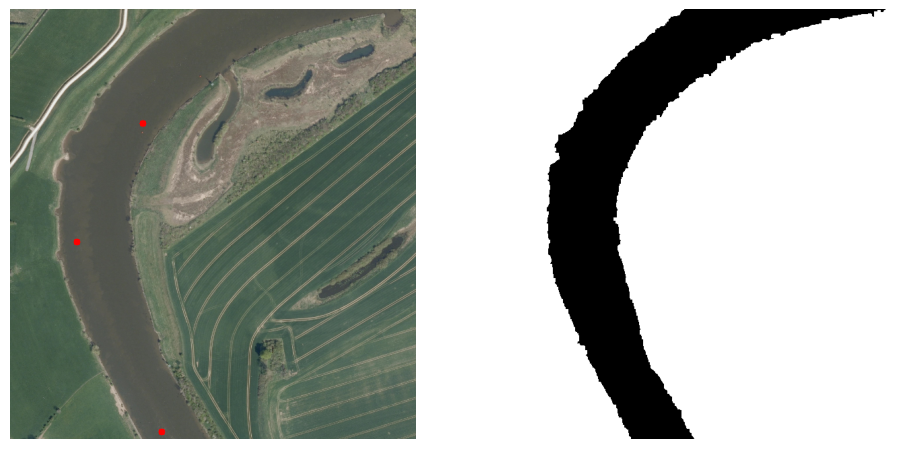

In [2]:
### BEGIN SOLUTION
src_img = cv.imread('example/image.tif')
rgb_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)
gray_img = cv.cvtColor(src_img,cv.COLOR_BGR2GRAY)

river_1 = np.zeros((src_img.shape[0],src_img.shape[1]),dtype = np.uint8)

seeds = [(347,99),(171,197),(629,225)]

for seed in seeds:
    rgb_img = cv.circle(rgb_img,(seed[1],seed[0]),5,(255,0,0),-1)
    mask = skimage.segmentation.flood(gray_img,seed,connectivity=1,tolerance=8)
    river_1[mask] = 255

kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
river_1 = cv.morphologyEx(river_1, cv.MORPH_CLOSE, kernel)
### END SOLUTION


plt.figure(figsize=(12, 6), dpi=96)
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(river_1,cmap='binary')
plt.axis('off')
plt.show()

In [3]:
### BEGIN HIDDEN TESTS
try: 
   assert river_1.dtype == np.uint8
except: 
   print('Element type of variable river_1 is not correct. uint8 expected')

test_data = np.fromfile('example/testB.bin',dtype = np.uint8)
test_data.shape = (river_1.shape[0], river_1.shape[1])

try: 
   for seed in seeds:
      if(test_data[seed[0],seed[1]]!=255):
         raise 
except: 
   print("Seed position is not suitable. Please reset seed.")

try: 
   assert (abs(test_data-river_1)).sum()<500 
except: 
   print("Incorrect segmentation. Area check didn't pass. Correct segmentation should looks like:")
   plt.imshow(test_data,cmap='binary')
   plt.axis('off')
   plt.show()

### END HIDDEN TESTS

### Task 2: Watershed Transformation
In this task you will use watershed algorithm to segment the river and both riverbanks in the given image. In order to prevent `oversegmentation`, `cv.watershed()` in `OpenCV` implements one of the variants of watershed, non-parametric marker-based segmentation algorithm, described in [paper](https://ieeexplore.ieee.org/document/785528). Therefore, you should choose reasonable marker as parameter of `cv.watershed()`.

Steps:
1. load the image from `'example/image.tif'` and convert it into a RGB image.
2. Use region growing method to segment both riverbanks in variable `river_1`, save the result in binary image(0 and 255).
3. Using code in the assignment 3, get the middle line of `river_1`, save the result in binary image(0 and 255).
4. Merge the result above into one binary image . 
5. Label the binary image. (read Hints 1 in below) 
6. Use watershed method to segment `src_img`. Save the result in `river_2`. The label in `river_2` should be 1,2,3 with the order "left riverbank", "river" and "right riverbank". The label of boundry should be -1.

Hints:
1. Function [cv.connectedComponents](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gaedef8c7340499ca391d459122e51bef5) to computes the connected components labeled image of boolean image
2. Function [cv.watershed](https://docs.opencv.org/4.x/d3/d47/group__imgproc__segmentation.html#ga3267243e4d3f95165d55a618c65ac6e1) to use watershed segmentation
3. Check [tutorial 1](https://docs.opencv.org/3.4/d3/db4/tutorial_py_watershed.html) and [tutorial 2](https://docs.opencv.org/4.x/d2/dbd/tutorial_distance_transform.html) to understand how to use `cv.watershed`.

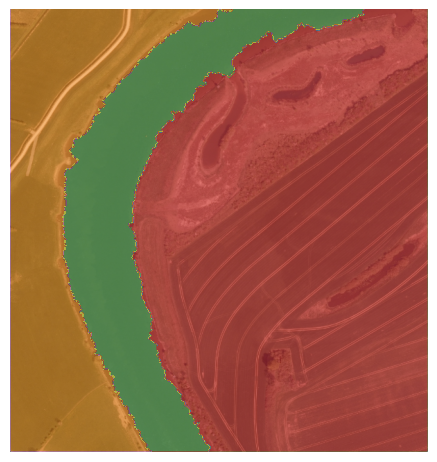

In [4]:
### BEGIN SOLUTION
def get_middle_line(img,threshold):
    dist = cv.distanceTransform(img, cv.DIST_L2, 3)
    cv.normalize(dist, dist, 0, 1.0, cv.NORM_MINMAX)
    threshold, thresholded_dist = cv.threshold(dist, threshold, 1.0, cv.THRESH_BINARY)
    middle_line_index = skimage.morphology.skeletonize(thresholded_dist)
    return middle_line_index


src_img = cv.imread('example/image.tif')
rgb_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)

binary_map = np.zeros((src_img.shape[0], src_img.shape[1]),dtype=np.uint8)
left_bank = np.zeros((src_img.shape[0],src_img.shape[1]),dtype = np.uint8)
mask = skimage.segmentation.flood(river_1,(0,0),connectivity=1,tolerance=1)
binary_map[mask] = 255
right_bank = np.zeros((src_img.shape[0],src_img.shape[1]),dtype = np.uint8)
mask = skimage.segmentation.flood(river_1,(river_1.shape[0]-1,river_1.shape[1]-1),connectivity=1,tolerance=1)
binary_map[mask] = 255
binary_map[get_middle_line(river_1,0.5)] = 255

ret, markers = cv.connectedComponents(binary_map)
river_2 = cv.watershed(src_img,markers)
### END SOLUTION


plt.figure(figsize=(6, 6), dpi=96)
plt.imshow(rgb_img)
plt.imshow(river_2, cmap=plt.cm.Set1_r, alpha=.5)
plt.axis('off')
plt.show()

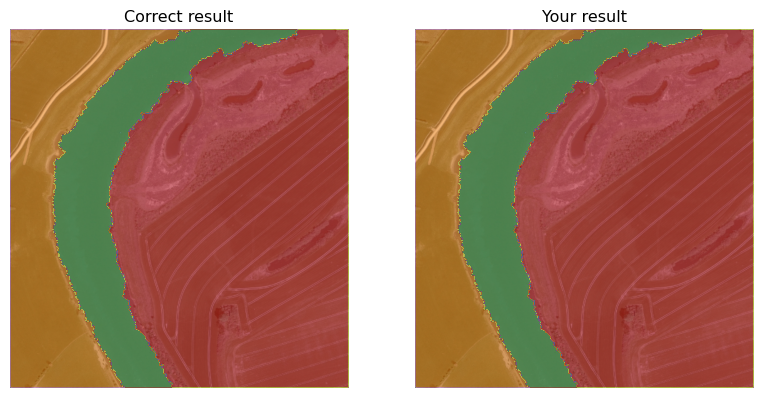

In [5]:
### BEGIN HIDDEN TESTS
test_data = np.fromfile('example/testA.bin',dtype = np.int32)
test_data.shape = (river_2.shape[0], river_2.shape[1])

plt.figure(figsize=(10, 8), dpi=96)
plt.subplot(1,2,1)
plt.title('Correct result')
plt.imshow(src_img)
plt.imshow(test_data, cmap=plt.cm.Set1_r, alpha=.5)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Your result')
plt.imshow(src_img)
plt.imshow(river_2, cmap=plt.cm.Set1_r, alpha=.5)
plt.axis('off')
plt.show()

try: 
   assert river_2[70,70] == 1 and river_2[300,120] == 2 and river_2[400,400] == 3
except: 
   print("Incorrcet markers number order. The left side should be 1, the river part should be 2, the right part should be 3.")

try: 
   assert (abs(test_data-river_2)).sum()<3000 
except: 
   print("Incorrect segmentation. Area check didn't pass.")
### END HIDDEN TESTS

### Task 3: Mean Shift Segmentation
In this task you will use mean shift algorithm to segment the picture.

Steps:
1. load the image from `'example/image2.tif'` and convert it into a RGB image.
2. Use mean shift algorithm to segment the loaded picture. (read Hint 1 in below) 

The parameter setting is: 
- spatialRad = 30
- colorRad = 20
- maxPyrLevel = 5


Hints:
1. Function [cv.pyrMeanShiftFiltering](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9fabdce9543bd602445f5db3827e4cc0) to do mean shift segmentation

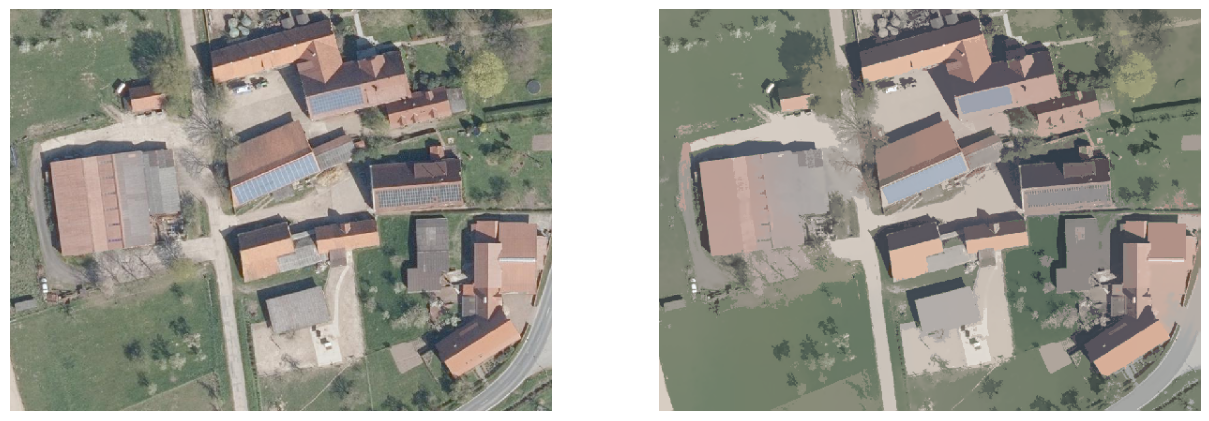

In [6]:
### BEGIN SOLUTION
src_img = cv.imread('example/image2.tif')
rgb_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)
spatialRad = 30
colorRad = 20
maxPyrLevel = 5
result = cv.pyrMeanShiftFiltering(rgb_img,spatialRad,colorRad,maxPyrLevel)
### END SOLUTION

plt.figure(figsize=(16, 8), dpi=96)
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(result)
plt.axis('off')
plt.show()

In [7]:
### BEGIN HIDDEN TESTS
test_data = np.fromfile('example/testC.bin',dtype = np.uint8)
test_data.shape = (rgb_img.shape[0], rgb_img.shape[1],3)

try: 
   assert (result==test_data).all()
except: 
   print("The result seems to be different. Try again with correct parameters.") 

### END HIDDEN TESTS

### Task 4: Simple Linear Iterative Clustering (SLIC) superpixels algorithm
In this task you will try to create superpixels in the given picture.

Steps:
1. load image from `'example/image2.tif'` and convert it into a RGB image.
2. Initialize superpixels creater on the loaded image. (Read Hint 1)
3. Use `iterate()` function to calculates the superpixel segmentation on a given image with the initialized parameters.
4. Use `enforceLabelConnectivity()` function to enforce label connectivity.
5. Set the counter of superpixels into (255,0,0) in `rgb_img`.

The parameter setting is: 
- region_size=30
- ruler=10
- min_element_size =20
- num_iterations = 5

Hints:
1. Function [cv.ximgproc.createSuperpixelSLIC](https://docs.opencv.org/3.4/df/d6c/group__ximgproc__superpixel.html#gacf29df20eaca242645a8d3a2d88e6c06) to create superpixels.
2. Infomation about [SuperpixelSLIC in OpenCV](https://docs.opencv.org/3.4/d3/da9/classcv_1_1ximgproc_1_1SuperpixelSLIC.html)

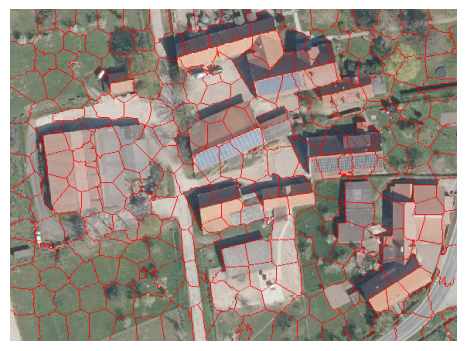

In [8]:
### BEGIN SOLUTION
src_img = cv.imread('example/image2.tif')
rgb_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)

min_element_size = 20
num_iterations = 5

slic = cv.ximgproc.createSuperpixelSLIC(rgb_img,region_size=30,ruler=10)
slic.iterate(num_iterations)
slic.enforceLabelConnectivity(min_element_size)

contour_mask = slic.getLabelContourMask(False)
number_slic = slic.getNumberOfSuperpixels()
rgb_img[0 < contour_mask] = (255, 0, 0)
### END SOLUTION

plt.figure(figsize=(6, 6), dpi=96)
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

In [9]:
### BEGIN HIDDEN TESTS
rgb_img.tofile('example/testZ.bin')
test_data = np.fromfile('example/testZ.bin',dtype = np.uint8)
test_data.shape = (rgb_img.shape[0], rgb_img.shape[1],3)

try: 
   assert (rgb_img == test_data).all()
except: 
   print("Incorrect super pixels. It should looks like:")
   plt.figure()
   plt.imshow(test_data)
   plt.axis('off')
   plt.show()

### END HIDDEN TESTS

## Extraction of edges

### Task 5: Douglas Peuke Algorithm
In this task you will use Douglas Peuke algorithm to approximates a polygonal curve. You will try to 'smooth' the boundary of the Leine River in Hannover.

Steps:
1. load image from `'example/image3.tif'` and convert it into a RGB image and a grayscale image. Create a copy of `rgb_img` as `result_img`.
2. Use region growing method to segment the Leine river with given seeds, (connectivity=1,tolerance=15), save the result in `river_3`
3. Fulfill the river using closing operation with rectangular kernel of size 5x5.
4. find contours of `river_3` with parameter `cv.RETR_EXTERNAL`, `cv.CHAIN_APPROX_SIMPLE`.
5. Use Douglas Peuke algorithm to approximates a polygonal curve of the founded contour (epsilon=4). Save the result in `douglas_peuke_result`.
6. Draw the original contour(green, thickness = 3) on `rgb_img` and the Douglas Peuke result(red, thickness = 3) on `result_img`.

Hints:
1. Function [cv.findContours](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) and [cv.drawContours](https://docs.opencv.org/4.x/d6/d6e/group__imgproc__draw.html#ga746c0625f1781f1ffc9056259103edbc) to find and draw contours.
2. Function [cv.approxPolyDP](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c)

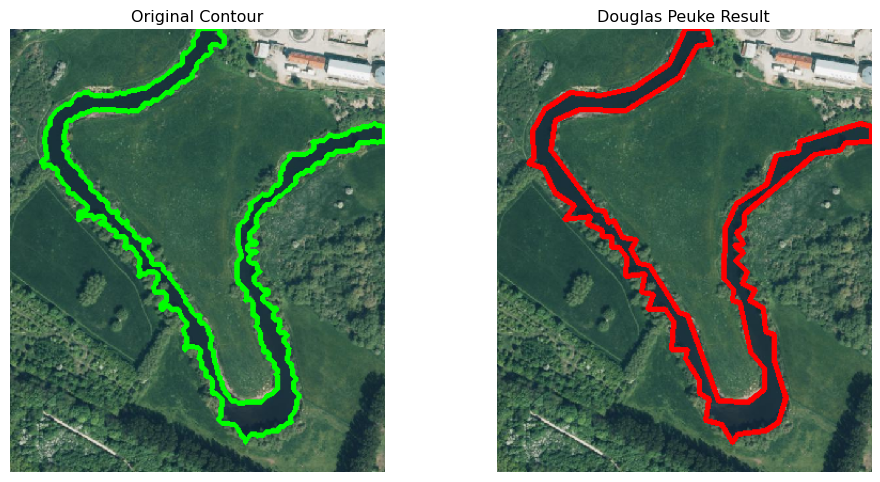

In [10]:
seeds = [(145,61),(361,240)]


### BEGIN SOLUTION
src_img = cv.imread('example/image3.tif')
rgb_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)
result_img = rgb_img.copy()
gray_img = cv.cvtColor(src_img,cv.COLOR_BGR2GRAY)

river_3 = np.zeros((src_img.shape[0],src_img.shape[1]),dtype = np.uint8)

for seed in seeds:
    mask = skimage.segmentation.flood(gray_img,seed,connectivity=1,tolerance=15)
    river_3[mask] = 1


kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
river_3 = cv.morphologyEx(river_3, cv.MORPH_CLOSE, kernel)

contours,hierarchy  = cv.findContours(river_3, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
rgb_img = cv.drawContours(rgb_img,contours,-1,(0,255,0),3)
douglas_peuke_result = cv.approxPolyDP(contours[0],4,True)
result_img = cv.drawContours(result_img,[douglas_peuke_result],-1,(255,0,0),3)
### END SOLUTION


plt.figure(figsize=(12, 6), dpi=96)
plt.subplot(1,2,1)
plt.title('Original Contour')
plt.imshow(rgb_img)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Douglas Peuke Result')
plt.imshow(result_img)
plt.axis('off')
plt.show()

In [11]:
### BEGIN HIDDEN TESTS
test_data = np.fromfile('example/testQ.bin',dtype = np.int32)
test_data.shape = douglas_peuke_result.shape

try: 
   assert (douglas_peuke_result == test_data).all()
except: 
   print("Incorrect douglas peuke result.")

### END HIDDEN TESTS

### Task 6: Hough transformation
In this task you will use Hough transformation to detect the four small fountains in the Herrenhausen Gardens of Hannover.


Steps:
1. load image from `'example/image4.tif'` and convert it into a RGB image and a grayscale image.
2. Threshold segment the variable `gray_img` using threshold value 190 and save the result in `binary_img`.
3. Use opening operation with rectangular kernel of size 5x5 to reduce noise in `binary_img`.
4. Use function `cv.findContours()` and `cv.drawContours()` to get the edges of `binary_img` and save the result in `edges`(binary image).
5. Implement hough circle transformation with given `hough_radii` to detect the center of four small fountains. Save the result in `cx`, `cy`.
6. Use `cv.circle()` to draw red circles(thickness=2) in `rgb_img`, indicating the position of founded fountains.

Hints:
1. Function [skimage.transform.hough_circle](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_circle) to implement hough transformation.
2. Function [skimage.transform.hough_circle_peaks](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.hough_circle_peaks) to find the maxima in hough transformation result.
3. Watch [this tutorial](https://scikit-image.org/docs/stable/auto_examples/edges/plot_circular_elliptical_hough_transform.html#sphx-glr-auto-examples-edges-plot-circular-elliptical-hough-transform-py) to learn about how to use functions above.

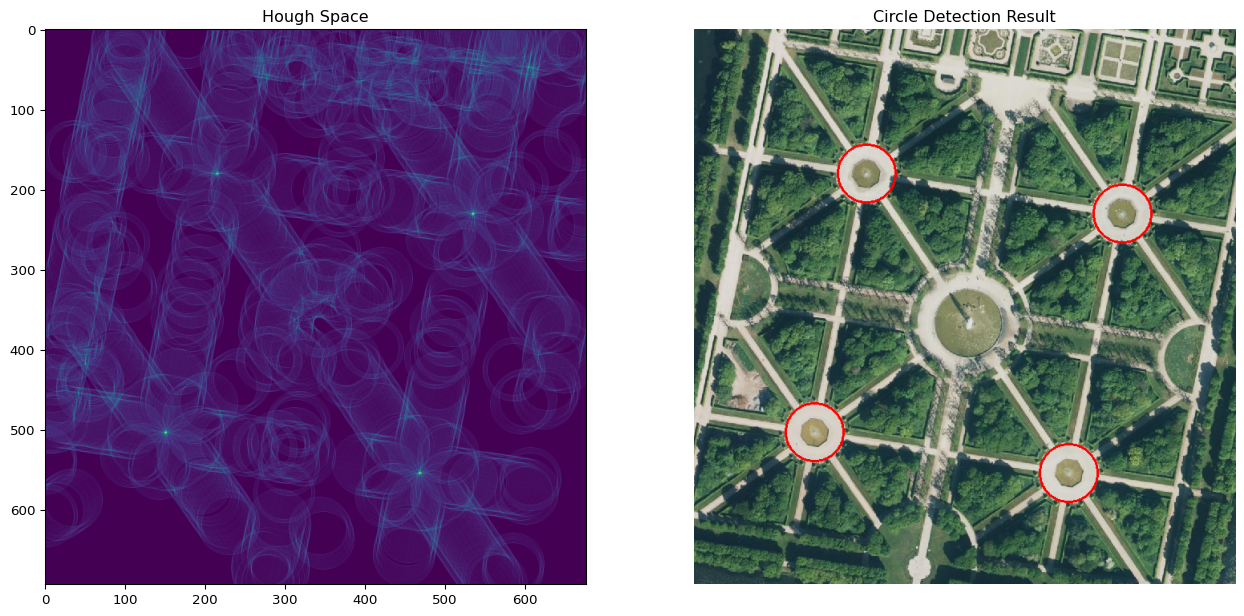

In [12]:
hough_radii = [36]


### BEGIN SOLUTION
src_img = cv.imread('example/image4.tif')
rgb_img = cv.cvtColor(src_img,cv.COLOR_BGR2RGB)
gray_img = cv.cvtColor(src_img,cv.COLOR_BGR2GRAY)

threshold2,binary_img = cv.threshold(gray_img,190,255,cv.THRESH_BINARY)
kernel = cv.getStructuringElement(cv.MORPH_RECT,(5,5))
binary_img = cv.morphologyEx(binary_img, cv.MORPH_OPEN, kernel)

edges = np.zeros((src_img.shape[0],src_img.shape[1]),dtype = np.uint8)

contours,hierarchy  = cv.findContours(binary_img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
edges = cv.drawContours(edges,contours,-1,(255),1)

hough_result = skimage.transform.hough_circle(edges, hough_radii)
accums, cx, cy, radii = skimage.transform.hough_circle_peaks(hough_result,hough_radii,total_num_peaks=4)

for center_y, center_x, radius in zip(cy, cx, radii):
    cv.circle(rgb_img,(center_x,center_y),radius,(255,0,0),2)
### END SOLUTION


plt.figure(figsize=(16, 8), dpi=96)
plt.subplot(1,2,1)
plt.title('Hough Space')
plt.imshow(hough_result[0])
plt.subplot(1,2,2)
plt.title('Circle Detection Result')
plt.imshow(rgb_img)
plt.axis('off')
plt.show()

In [13]:
### BEGIN HIDDEN TESTS
test_data = np.fromfile('example/testK.bin',dtype = np.float64)
test_data.shape = (src_img.shape[0],src_img.shape[1])

try: 
   assert (hough_result[0] == test_data).all()
except: 
   print("Incorrect hough transformation result. Hough_result[0] should looks like:")
   plt.title('Correct Hough Space')
   plt.imshow(test_data)
   plt.show() 
### END HIDDEN TESTS